# Обработка и визуализация данных по опционам

Мы выгрузили данные о транзакциях с опционами с [Чикагской биржи опцонов](https://www.cboe.com/us/options/market_statistics/flex_trade_reports/) за период 02.02.25-20.02.25.


Признаки:

* Время транзакции - данные представлены посекундно.
* price - цена опциона, в долларах
* size - объем сделки, шт
* osi_root - Название индекса, к которому привязан опцион, цифра означает биржу,
на которой был "listed" опцион (2 - Нью-Йоркская биржа, 4 - Чикагская)
* expire_date - дата эксперации
* call_put_flag - динарный показатель кол - C, или пут - P опциона
* strike_price - цена страйка, $
* spread - нам не пригодится

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sts
from math import *
import glob
from IPython.display import display
import statistics
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Подгружаем таблицы с данными и сводим их в единую таблицу по опционам
names = glob.glob(r'/content/drive/MyDrive/Андан Проект/Данные опционы/*.xlsx',\
                  recursive=True)
cont = []
for i in range(len(names)):
    df = pd.read_excel(names[i], index_col=0)
    cont.append(df)
totaldata = pd.concat(cont)
df_options = totaldata.reset_index()

In [ ]:
df_options.isnull().sum()

,0
transact_time,0
price,0
size,0
osi_root,38
expire_date,0
call_put_flag,38
strike_price,0
spread,0


Пропусков не так много, поэтому убираем строки со значением NAN

In [ ]:
 df_options = df_options.dropna()

In [ ]:
# Удаляем цифру в начале названия тикера, т.к. цифра означает биржу,
# на которой был "listed" опцион (2 - Нью-Йоркская биржа, 4 - Чикагская)
df_options['ticker'] = df_options['osi_root'].apply(lambda x: x[1:])
df_options.drop(columns=['osi_root'], inplace=True)

# неинформативное значение
df_options = df_options.drop('spread', axis=1)

In [ ]:
display(df_options['price'].describe(), df_options['size'].describe(),\
        df_options['strike_price'].describe())

,price
count,23634.000000
mean,168.781258
std,761.806840
min,0.010000
25%,1.620000
50%,11.730000
75%,65.450000
max,20706.000000


,size
count,23634.000000
mean,566.925362
std,3157.606639
min,1.000000
25%,3.000000
50%,22.000000
75%,125.000000
max,116382.000000


,strike_price
count,23634.000000
mean,1291.109111
std,2979.701949
min,0.010000
25%,88.000000
50%,473.370000
75%,605.480000
max,27246.320000


Отбираем самые значимые индексы. Мы решили оставить 3 самых популярных по количеству транзакций. SPY, SPX, QQQ

In [ ]:
df_options['ticker'].value_counts().head(5)

,count
ticker,
SPY,11498
SPX,2718
QQQ,1462
IWM,956
MSTR,740


In [ ]:
# Оставляем 3 самых значимых по вкладу тикера
ticker_names = ('SPY', 'SPX', 'QQQ')
df_options = df_options[df_options['ticker'].isin(ticker_names)]

In [ ]:
# Добавляем один час к времени, чтобы иметь возможность в будущем сравнивать
# одновременные торги на Чикагской бирже опционов (UTC -6)
# и торги акций на бирже в Нью-Йорке (UTC -5)
df_options['transact_time'] = df_options['transact_time'] + pd.Timedelta(hours=1)

<ipython-input-9-c02d61ca6426>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_options['transact_time'] = df_options['transact_time'] + pd.Timedelta(hours=1)


In [ ]:
# После удаления тикеров с небольшими объемами, пересоздаем индекс
df_options = df_options.reset_index()
df_options.drop(columns=['index'], inplace=True)

Рассчитаем время до даты эксперации

In [ ]:
df_options['days_before_expire_date'] = df_options['expire_date'] -\
df_options['transact_time'].apply(lambda x: x.floor('d'))

In [ ]:
# Найдем объем в долларах купленных опционов
df_options['buy_volume'] = df_options['price'] * df_options['size']

In [ ]:
df_options['buy_volume'].describe().round(2)

,buy_volume
count,15678.00
mean,12597.03
std,156953.58
min,0.01
25%,29.20
50%,229.23
75%,1210.36
max,7131605.40


In [ ]:
# Выгрузим обработанные данные для дальнейших мохинаций
path = r'/content/drive/MyDrive/Андан Проект/Обработанные данные/'
for ticker in ticker_names:
    df_options[df_options['ticker'] == ticker].to_excel(path + f'Options_{ticker}.xlsx',
                                                        index=False)

# Ура, ура, рисуем красивые графики

In [ ]:
# let's create our color styles
our_colors = ['#F3E8FF', '#DCFCE7', '#FFEDD5', '#9333EA', '#16A34A', '#EA580C']

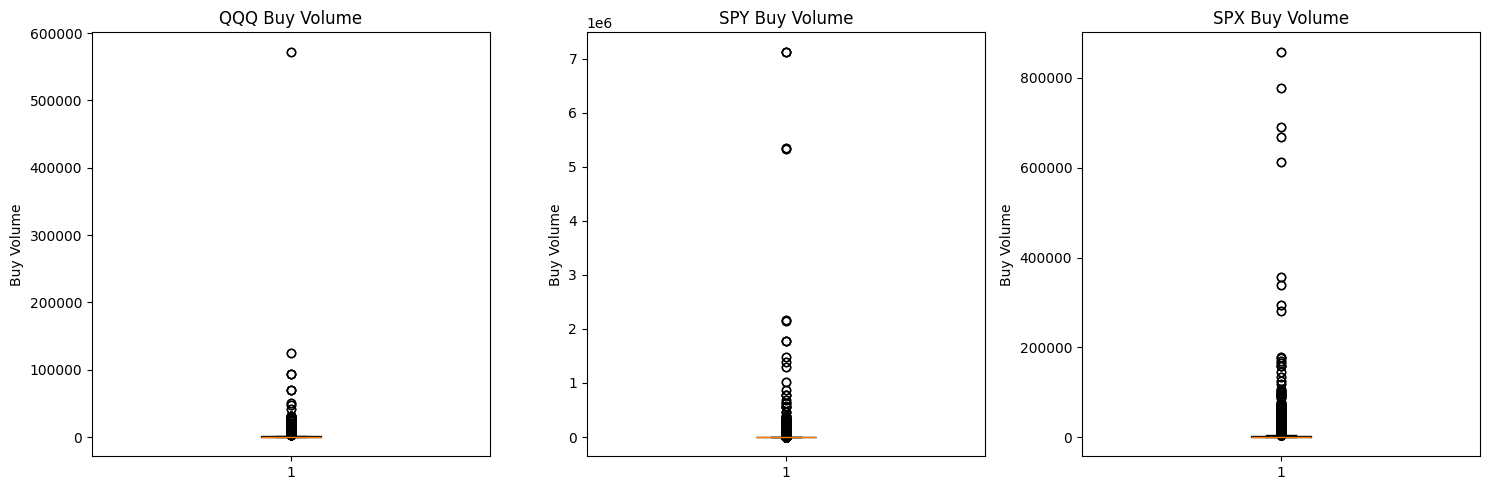

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Boxplot для QQQ
axes[0].boxplot(df_options[df_options['ticker'] == 'QQQ']['buy_volume'], vert=True, patch_artist=True, boxprops=dict(facecolor=our_colors[0]))
axes[0].set_title('QQQ Buy Volume')
axes[0].set_ylabel('Buy Volume')

# Boxplot для SPY
axes[1].boxplot(df_options[df_options['ticker'] == 'SPY']['buy_volume'], vert=True, patch_artist=True, boxprops=dict(facecolor=our_colors[1]))
axes[1].set_title('SPY Buy Volume')
axes[1].set_ylabel('Buy Volume')

# Boxplot для SPX
axes[2].boxplot(df_options[df_options['ticker'] == 'SPX']['buy_volume'], vert=True, patch_artist=True, boxprops=dict(facecolor=our_colors[2]))
axes[2].set_title('SPX Buy Volume')
axes[2].set_ylabel('Buy Volume')

plt.tight_layout()
plt.show()

Построим распределение объема покупки по тикерам
Из ящика с усами мы узнали, что в этом показателя много выбросов
Эксперементально пришлт к тому, что 0.8 допустимый квантиль, чтобы графики были хоть чуточки репрезентативными
В целом в основном наблюдаются микроскопические объемы покупки, видимо из-за вложенного плеча

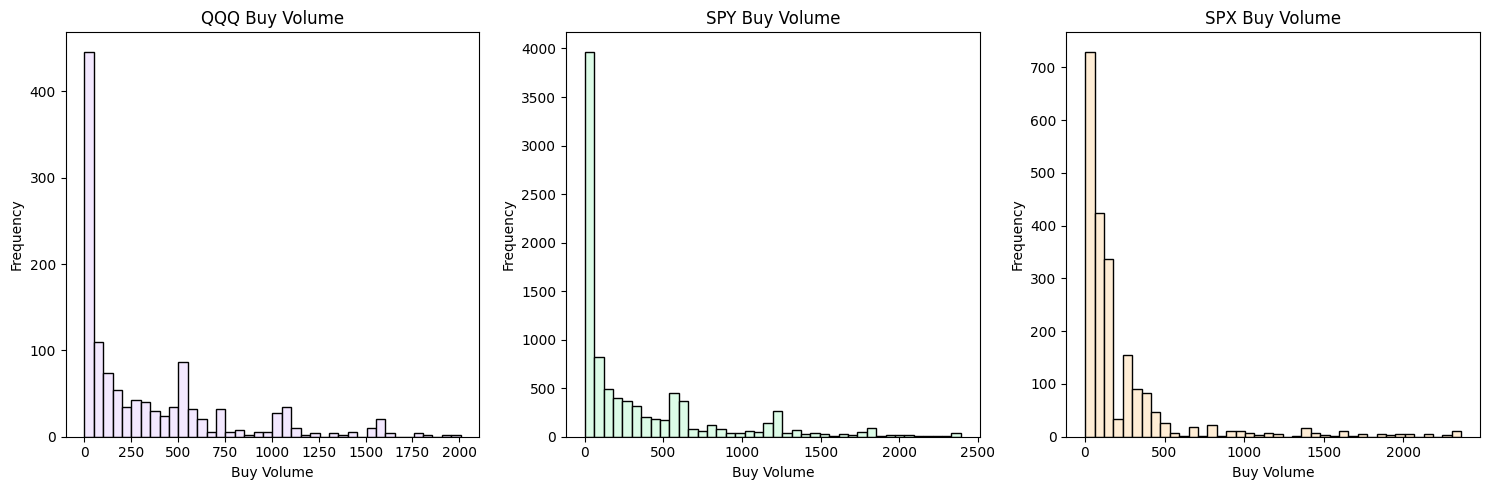

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Гистограмма для QQQ
axes[0].hist(
    df_options[df_options['ticker'] == 'QQQ']['buy_volume'][df_options['buy_volume'] < df_options['buy_volume'].quantile(0.8)],
    bins=40,
    edgecolor='black',
    color=our_colors[0]
)
axes[0].set_title('QQQ Buy Volume')
axes[0].set_xlabel('Buy Volume')
axes[0].set_ylabel('Frequency')

# Гистограмма для SPY
axes[1].hist(
    df_options[df_options['ticker'] == 'SPY']['buy_volume'][df_options['buy_volume'] < df_options['buy_volume'].quantile(0.8)],
    bins=40,
    edgecolor='black',
    color=our_colors[1]
)
axes[1].set_title('SPY Buy Volume')
axes[1].set_xlabel('Buy Volume')
axes[1].set_ylabel('Frequency')

# Гистограмма для SPX
axes[2].hist(
    df_options[df_options['ticker'] == 'SPX']['buy_volume'][df_options['buy_volume'] < df_options['buy_volume'].quantile(0.8)],
    bins=40,
    edgecolor='black',
    color=our_colors[2]
)
axes[2].set_title('SPX Buy Volume')
axes[2].set_xlabel('Buy Volume')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Построим распределение страйков по тикерам
Мы можем наблюдать большое количество значение в районе нуля и значения индекса
Это связано с синтетической репликацией фьючерса через опционы с нулевыем страйком
И покупкой опционов с центральным страйком

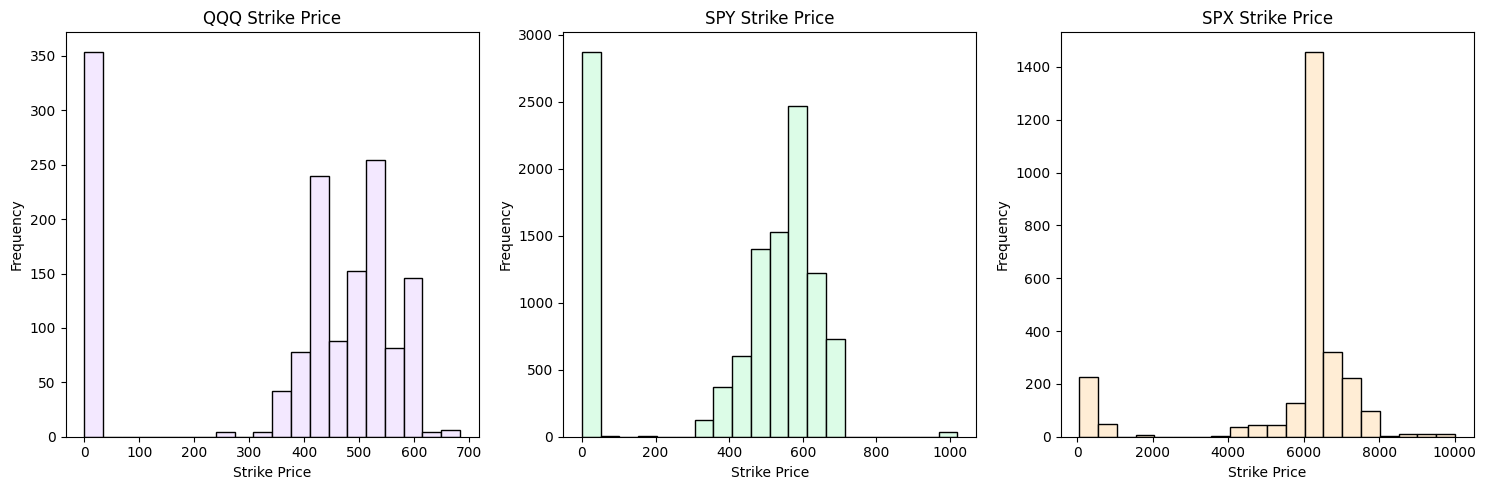

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Гистограмма для QQQ
axes[0].hist(
    df_options[df_options['ticker'] == 'QQQ']['strike_price'][df_options['strike_price'] < df_options['strike_price'].quantile(0.98)],
    bins=20,
    color = our_colors[0],
    edgecolor='black'
)
axes[0].set_title('QQQ Strike Price')
axes[0].set_xlabel('Strike Price')
axes[0].set_ylabel('Frequency')

# Гистограмма для SPY
axes[1].hist(
    df_options[df_options['ticker'] == 'SPY']['strike_price'][df_options['strike_price'] < df_options['strike_price'].quantile(0.99)],
    bins=20,
    color = our_colors[1],
    edgecolor='black'
)
axes[1].set_title('SPY Strike Price')
axes[1].set_xlabel('Strike Price')
axes[1].set_ylabel('Frequency')

# Гистограмма для SPX
axes[2].hist(
    df_options[df_options['ticker'] == 'SPX']['strike_price'][df_options['strike_price'] < df_options['strike_price'].quantile(0.99)],
    bins=20,
    color = our_colors[2],
    edgecolor='black'
)
axes[2].set_title('SPX Strike Price')
axes[2].set_xlabel('Strike Price')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Построим распределение цен опциона по тикерам
Такое распределение напрямую вытекает из диаграммы по страйкам
Опционы с центральным страйком стоят ближе к нулю
Опционы с нулевым страйком чуть больше значения индекса

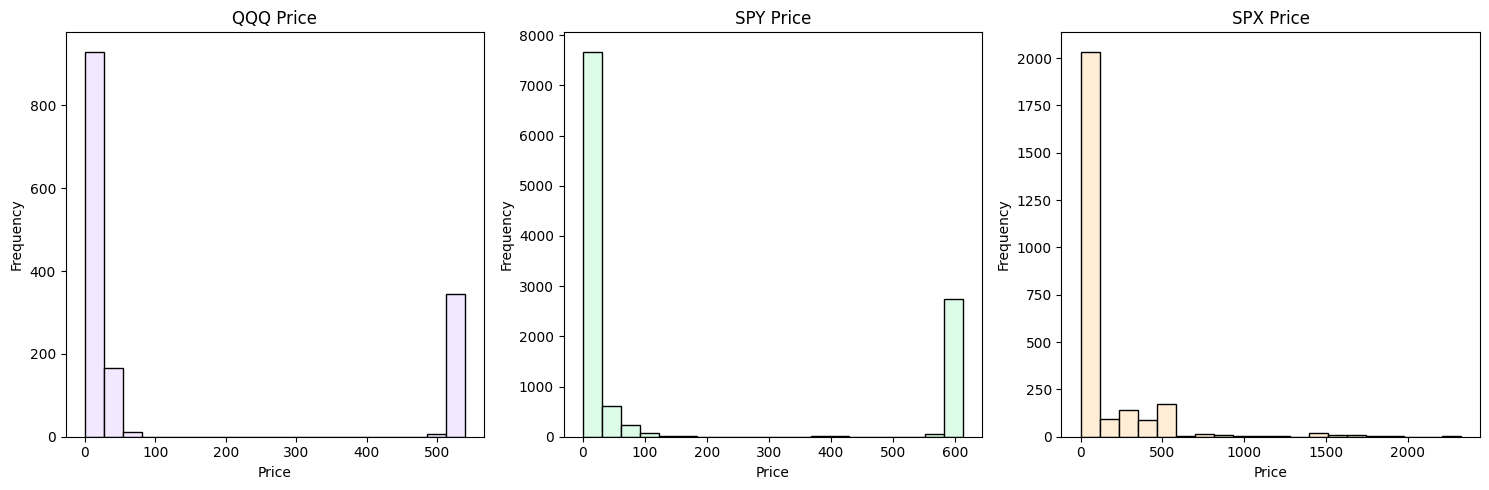

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Гистограмма для QQQ
axes[0].hist(
    df_options[df_options['ticker'] == 'QQQ']['price'][df_options['price'] < df_options['price'].quantile(0.98)],
    bins=20,
    color = our_colors[0],
    edgecolor='black'
)
axes[0].set_title('QQQ Price')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Frequency')

# Гистограмма для SPY
axes[1].hist(
    df_options[df_options['ticker'] == 'SPY']['price'][df_options['price'] < df_options['price'].quantile(0.99)],
    bins=20,
    color = our_colors[1],
    edgecolor='black'
)
axes[1].set_title('SPY Price')
axes[1].set_xlabel('Price')
axes[1].set_ylabel('Frequency')

# Гистограмма для SPX
axes[2].hist(
    df_options[df_options['ticker'] == 'SPX']['price'][df_options['price'] < df_options['price'].quantile(0.99)],
    bins=20,
    color = our_colors[2],
    edgecolor='black'
)
axes[2].set_title('SPX Price')
axes[2].set_xlabel('Price')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Построим распределение дней до экспирации по тикерам
Почему-то SPX имеет совсем иное распределение, с чем это связано непонятно

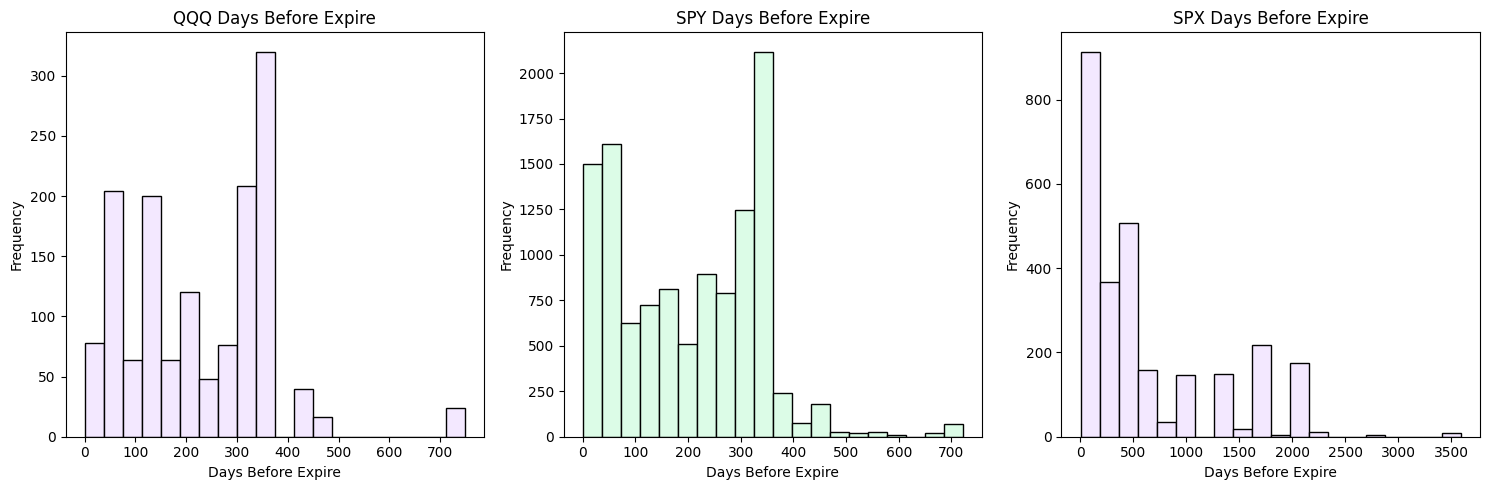

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Гистограмма для QQQ
axes[0].hist(
    df_options[df_options['ticker'] == 'QQQ']['days_before_expire_date'].dt.days,
    bins=20,
    edgecolor='black',
    color=our_colors[0]
)
axes[0].set_title('QQQ Days Before Expire')
axes[0].set_xlabel('Days Before Expire')
axes[0].set_ylabel('Frequency')

# Гистограмма для SPY
axes[1].hist(
    df_options[df_options['ticker'] == 'SPY']['days_before_expire_date'].dt.days,
    bins=20,
    edgecolor='black',
    color=our_colors[1]
)
axes[1].set_title('SPY Days Before Expire')
axes[1].set_xlabel('Days Before Expire')
axes[1].set_ylabel('Frequency')

# Гистограмма для SPX
axes[2].hist(
    df_options[df_options['ticker'] == 'SPX']['days_before_expire_date'].dt.days,
    bins=20,
    edgecolor='black',
    color=our_colors[0]
)
axes[2].set_title('SPX Days Before Expire')
axes[2].set_xlabel('Days Before Expire')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
# Нам необходимо узнать моду страйкам, чтобы в дальнейшем сравнить стоимость опционов с значением индексов
statistics.mode(df_options[df_options['ticker'] == 'QQQ']['strike_price']), statistics.mode(df_options[df_options['ticker'] == 'SPY']['strike_price']), statistics.mode(df_options[df_options['ticker'] == 'SPX']['strike_price'])

(0.01, 0.01, 100.0)

In [ ]:
statistics.mode(df_options[df_options['ticker'] == 'QQQ']['expire_date']), statistics.mode(df_options[df_options['ticker'] == 'SPY']['expire_date']), statistics.mode(df_options[df_options['ticker'] == 'SPX']['expire_date'])

(Timestamp('2026-01-30 00:00:00'),
 Timestamp('2026-01-30 00:00:00'),
 Timestamp('2025-03-21 00:00:00'))

In [ ]:
# Нам необходимо узнать моды по датам экспирации, чтобы в дальнейшем сравнить стоимость опционов с значением индексов
statistics.mode(df_options[(df_options['ticker'] == 'QQQ') & (df_options['strike_price'] == 0.01)]['expire_date']), \
statistics.mode(df_options[(df_options['ticker'] == 'SPY') & (df_options['strike_price'] == 0.01)]['expire_date']), \
statistics.mode(df_options[(df_options['ticker'] == 'SPX') & (df_options['strike_price'] == 100)]['expire_date'])

(Timestamp('2025-08-08 00:00:00'),
 Timestamp('2025-02-28 00:00:00'),
 Timestamp('2026-02-06 00:00:00'))

In [ ]:
# До этого мы узнали моды по экспирации для фиксированных страйков, теперь сделаем наоборот
statistics.mode(df_options[(df_options['ticker'] == 'QQQ') & (df_options['expire_date'] == '2026-01-30 00:00:00')]['strike_price']), \
statistics.mode(df_options[(df_options['ticker'] == 'SPY') & (df_options['expire_date'] == '2026-01-30 00:00:00')]['strike_price']), \
statistics.mode(df_options[(df_options['ticker'] == 'SPX') & (df_options['expire_date'] == '2025-03-21 00:00:00')]['strike_price'])

(522.29, 601.82, 6132.0)

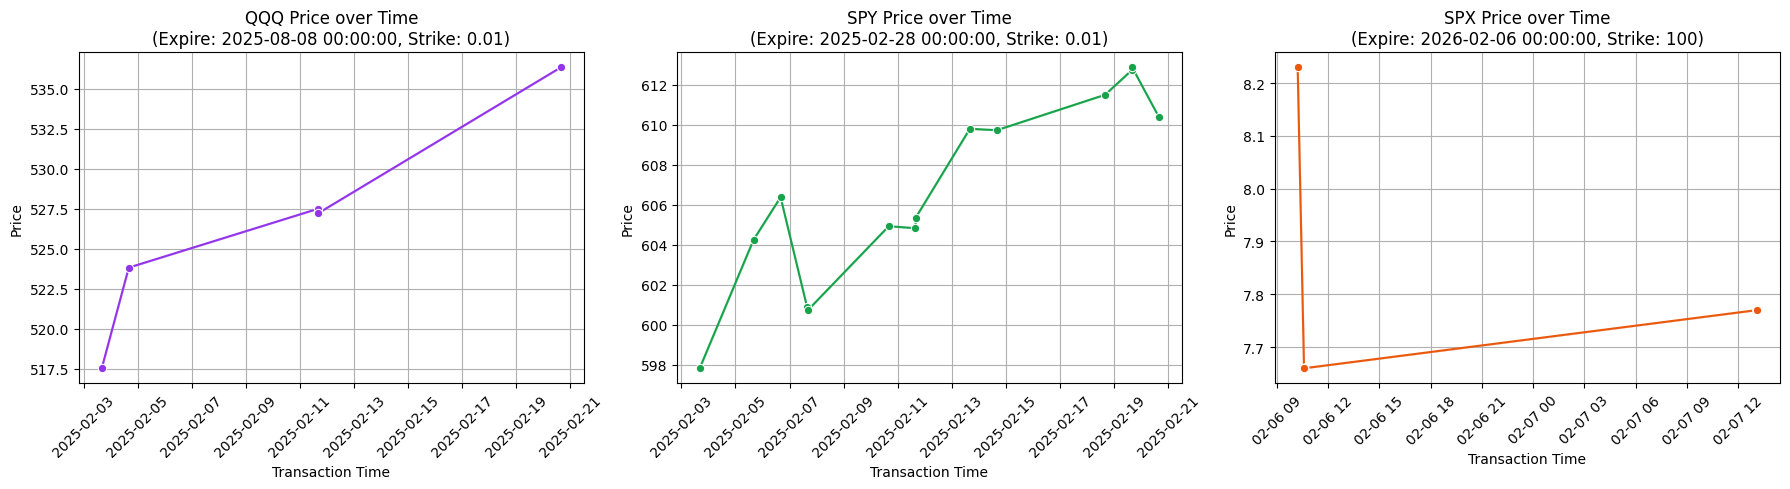

In [ ]:
# Построим для первого набора параметров, где мы сначала фильтровали по страйкам
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Уникальные параметры для каждого тикера
ticker_params = {
    'QQQ': {'expire_date': '2025-08-08 00:00:00', 'strike_price': 0.01},
    'SPY': {'expire_date': '2025-02-28 00:00:00', 'strike_price': 0.01},
    'SPX': {'expire_date': '2026-02-06 00:00:00', 'strike_price': 100}
}

# Построим графики для каждого тикера
for i, (ticker, params) in enumerate(ticker_params.items()):
    filtered_data = df_options[
        (df_options['ticker'] == ticker) &
        (df_options['expire_date'] == params['expire_date']) &
        (df_options['strike_price'] == params['strike_price'])
    ]

    # Строим линейный график на соответствующей оси
    sns.lineplot(
        x='transact_time',
        y='price',
        data=filtered_data,
        marker='o',
        ax=axes[i],
        color = our_colors[i+3]
    )

    axes[i].set_title(f'{ticker} Price over Time\n(Expire: {params["expire_date"]}, Strike: {params["strike_price"]})')
    axes[i].set_xlabel('Transaction Time')
    axes[i].set_ylabel('Price')
    axes[i].grid(True)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

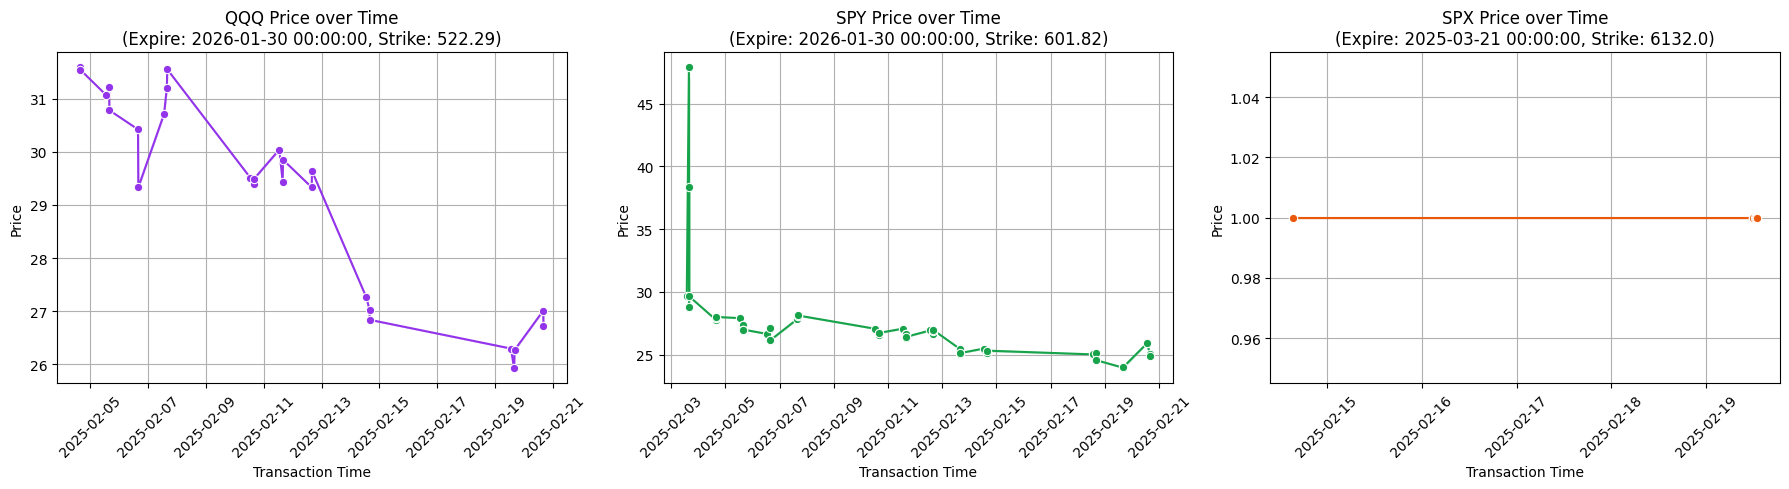

In [ ]:
# Построим для второго набора параметров, где мы сеачала фильтровали по датам экспирации
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Уникальные параметры для каждого тикера
ticker_params = {
    'QQQ': {'expire_date': '2026-01-30 00:00:00', 'strike_price': 522.29},
    'SPY': {'expire_date': '2026-01-30 00:00:00', 'strike_price': 601.82},
    'SPX': {'expire_date': '2025-03-21 00:00:00', 'strike_price': 6132.0}
}

# Построим графики для каждого тикера
for i, (ticker, params) in enumerate(ticker_params.items()):
    filtered_data = df_options[
        (df_options['ticker'] == ticker) &
        (df_options['expire_date'] == params['expire_date']) &
        (df_options['strike_price'] == params['strike_price'])
    ]

    # Строим линейный график на соответствующей оси
    sns.lineplot(
        x='transact_time',
        y='price',
        data=filtered_data,
        marker='o',
        ax=axes[i],
        color = our_colors[i+3]
    )

    axes[i].set_title(f'{ticker} Price over Time\n(Expire: {params["expire_date"]}, Strike: {params["strike_price"]})')
    axes[i].set_xlabel('Transaction Time')
    axes[i].set_ylabel('Price')
    axes[i].grid(True)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
df_options['transact_date'] = df_options['transact_time'].dt.date

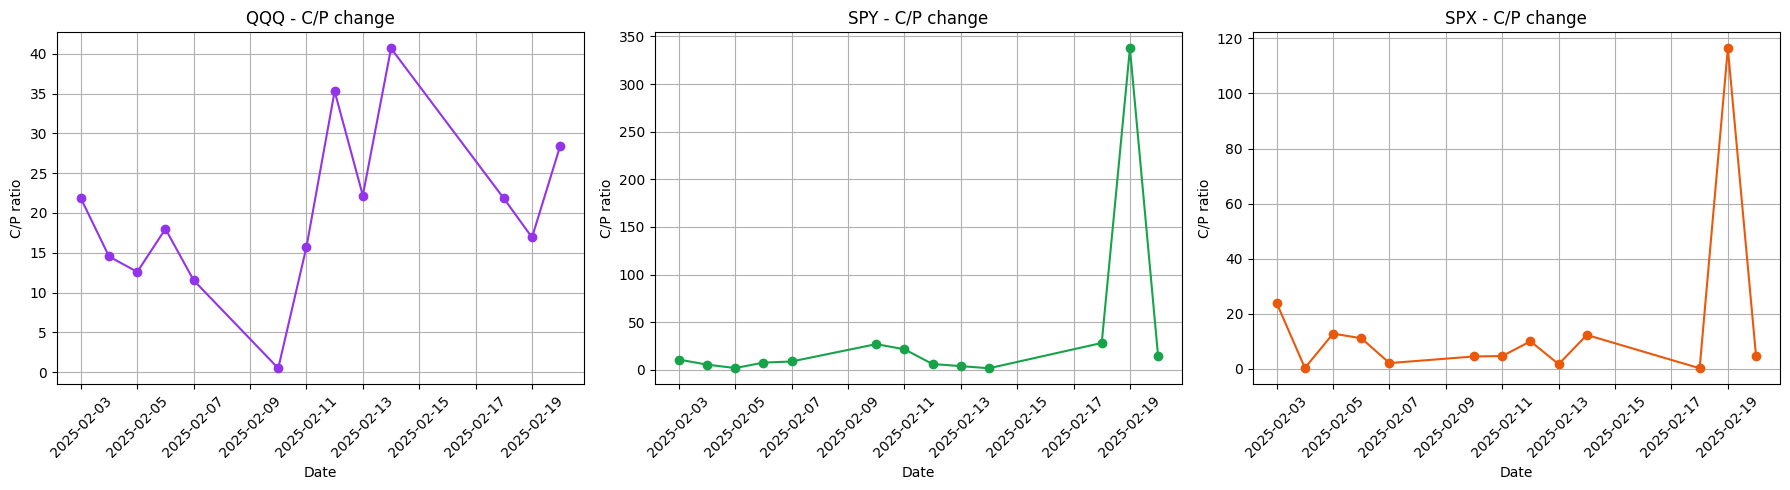

In [ ]:
# Построим соотношение объема купленных колл опционов к пут опционам в динамике
# Все bullish af
tickers = ['QQQ', 'SPY', 'SPX']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Построим графики для каждого тикера
for i, ticker in enumerate(tickers):
    df_ticker = df_options[df_options['ticker'] == ticker]

    df_grouped = df_ticker.groupby(['transact_date', 'call_put_flag'])['buy_volume'].sum().unstack(fill_value=0)
    # Рассчитываем соотношение C / P по суммарному объему
    df_grouped['C_P_ratio'] = df_grouped['C'] / df_grouped['P']

    # Строим график
    axes[i].plot(df_grouped.index, df_grouped['C_P_ratio'], marker='o', label=f'{ticker} C/P Ratio', color = our_colors[i+3])
    axes[i].set_title(f'{ticker} - C/P change')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('C/P ratio')
    axes[i].grid(True)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()